Goal: convert avi to some kind of numpy array
============

In [1]:
import cv2.cv as cv
import cv2

In [2]:
import numpy as np

# capture = cv.CaptureFromFile('videotest.avi')
# frames = []
# for i in xrange(200):
#     img = cv.QueryFrame(capture)
#     if img==None: break
# #     print type(img)
# #     tmp = cv.CreateImage(cv.GetSize(img),8,3)
# #     cv.CvtColor(img,tmp,cv.CV_BGR2RGB)
#     tmp = img
#     frames.append(np.asarray(cv.GetMat(tmp))) 
# frames = np.array(frames)


try:
    vidFile = cv2.VideoCapture('videotest.avi')
except:
    print "problem opening input stream"
    sys.exit(1)
if not vidFile.isOpened():
    print "capture stream not open"
    sys.exit(1)

nFrames = int(vidFile.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT)) # one good way of namespacing legacy openCV: cv2.cv.*
print "frame number: %s" %nFrames
fps = vidFile.get(cv2.cv.CV_CAP_PROP_FPS)
print "FPS value: %s" %fps

ret, frame = vidFile.read() # read first frame, and the return code of the function.
print frame.shape
frames = np.zeros((200,)+frame.shape)
for i in xrange(200):  # note that we don't have to use frame number here, we could read from a live written file.
#     cv2.imshow("frameWindow", frame)
    cv2.waitKey(int(1/fps*1000)) # time to wait between frames, in mSec
    ret, frames[i] = vidFile.read() # read next frame, get next return code

frame number: 19452
FPS value: 60.0
(480, 640, 3)


(200, 480, 640, 3)


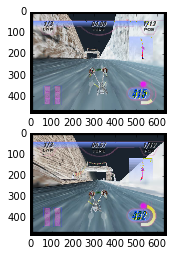

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
print frames.shape
plt.subplot(211)
plt.imshow(frames[100,:,:,:])
plt.subplot(212)
plt.imshow(frames[115,:,:,:])

Obtain VGG_S dataset:
--------


``!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg_cnn_s.pkl`` <-- already run, so removing from notebook for now.

Data Transformation and Preparation functions:
----

(200, 224, 224, 3)
(200, 3, 224, 224)


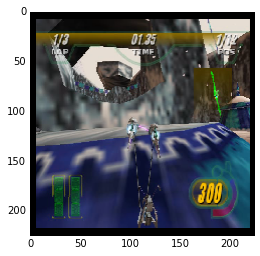

In [4]:
import io
import scipy.misc

def rescale_img(X):
    N,H,W,C = X.shape;
    XOut = np.zeros((N,224,224,C), dtype=np.uint8)
    for i in range(N):
        XOut[i,:,:,:] = scipy.misc.imresize(X[i,:,:,:], (224,224), interp="nearest")
    #im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    #im = im[::-1, :, :]

    return XOut;

framesResized = rescale_img(frames);
plt.imshow(framesResized[43,:,:,:])
# print framesResized[43,224/2,224/2,:]
# print frames[43,240,320,:]
# plt.imshow(frames[43,:,:,:])

# Swap the axes around for frames:
print framesResized.shape
framesResized = framesResized.swapaxes(1,2).swapaxes(1,3)
print framesResized.shape
del frames

## Importing Model

In [5]:
import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
# from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as PoolLayer
from lasagne.layers import LocalResponseNormalization2DLayer as NormLayer
from lasagne.utils import floatX

Using gpu device 1: GeForce GTX 780 (CNMeM is disabled)


In [12]:
def makeNeuralNet():
    net = {}
    net['input'] = InputLayer(shape=(None, 3, 224, 224))
    net['conv1'] = ConvLayer(net['input'], num_filters=96, filter_size=7, stride=2)
    net['norm1'] = NormLayer(net['conv1'], alpha=0.0001) # caffe has alpha = alpha * pool_size
    net['pool1'] = PoolLayer(net['norm1'], pool_size=3, stride=3, ignore_border=False)
    net['conv2'] = ConvLayer(net['pool1'], num_filters=256, filter_size=5)
    net['pool2'] = PoolLayer(net['conv2'], pool_size=2, stride=2, ignore_border=False)
    net['conv3'] = ConvLayer(net['pool2'], num_filters=512, filter_size=3, pad=1)
    net['conv4'] = ConvLayer(net['conv3'], num_filters=512, filter_size=3, pad=1)
    net['conv5'] = ConvLayer(net['conv4'], num_filters=512, filter_size=3, pad=1)
    net['pool5'] = PoolLayer(net['conv5'], pool_size=3, stride=3, ignore_border=False)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['drop6'] = DropoutLayer(net['fc6'], p=0.5)
#     net['fc7'] = DenseLayer(net['drop6'], num_units=4096)
#     net['drop7'] = DropoutLayer(net['fc7'], p=0.5)
#     net['fc8'] = DenseLayer(net['drop7'], num_units=1000, nonlinearity=lasagne.nonlinearities.softmax)
#     output_layer_vgg = net['fc8']
    ini = lasagne.init.HeUniform()
    net['_fc7'] = DenseLayer(net['drop6'], num_units=4096, W=ini)
    net['_drop7'] = DropoutLayer(net['_fc7'], p=0.5)
    net['_fc8out'] = DenseLayer(net['_drop7'], num_units=6, nonlinearity=lasagne.nonlinearities.softmax, W=ini)
    output_layer_driver = net['_fc8out']
    return net['drop6'], output_layer_driver
    

In [17]:
import pickle
import theano.tensor as T
import theano

NUM_EPOCHS = 200
BATCH_SIZE = 100
LEARNING_RATE = 0.000000001


model = pickle.load(open('vgg_cnn_s.pkl'))
# CLASSES = model['synset words']
MEAN_IMAGE = model['mean image']

vgg,driver = makeNeuralNet()
# print model['values']
lasagne.layers.set_all_param_values(vgg, model['values'][:12])
# Load VGG CNN S into the vgg net.

X = T.tensor4()
y = T.matrix()

# training output
output_train = lasagne.layers.get_output(driver, X, deterministic=False)
# evaluation output. Also includes output of transform for plotting
output_eval = lasagne.layers.get_output(driver, X, deterministic=True)
model_params = lasagne.layers.get_all_params(driver, trainable=True)

sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
# updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)
updates = lasagne.updates.adam(cost, model_params, learning_rate=LEARNING_RATE)

trainFn = theano.function([X, y], [cost, output_train], updates=updates, allow_input_downcast=True)
evalFn = theano.function([X], [output_eval])
# plt.imshow(np.swapaxes(MEAN_IMAGE,0,2).swapaxes(1,0))

#plt.imshow(MEAN_IMAGE)

In [18]:
THRESHOLD_CORRECT = 0.8
def estCorrectness(output, actual):
    return np.sum(np.sum((output>0.8)==(actual>0.8),  axis=-1)==6)
    
def train_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost_batch, output_train = trainFn(X_batch, y_batch)
        costs += [cost_batch]
        #output_train is a matrix of probabilities.
        correct += estCorrectness(output_train, y)

    return np.mean(costs), float(correct)/num_samples


def eval_epoch(X, y):
    output_eval = evalFn(X)
    return float(estCorrectness(output_eval, y)) / X.shape[0]

In [19]:
framesResized = framesResized - MEAN_IMAGE

In [20]:
%run 'InputProcessor.ipynb'

{128: 0, 4096: 1, 83886080: 4, 5242880: 3, 11534336: 2, 184549376: 5}


In [21]:
yLabel = fileToNPArray('inputtest.txt')
print yLabel[0]

Input file conversion complete.
[ 0.  0.  0.  0.  0.  0.]


In [22]:
data = {
    'X_train': framesResized[:100],
    'y_train': yLabel[:100],
    'X_valid': framesResized[130:150],
    'y_valid': yLabel[130:150],
    'X_test': framesResized[150:],
    'y_test': yLabel[150:]
}


valid_accs, train_accs, test_accs = [], [], []
try:
    for n in range(NUM_EPOCHS):
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'])
        valid_acc = eval_epoch(data['X_valid'], data['y_valid'])
        test_acc = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]

        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.7
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))

        print "Epoch {0}: Train cost {1}, Train acc {2}, val acc {3}, test acc {4}".format(
                n, train_cost, train_acc, valid_acc, test_acc)
except KeyboardInterrupt:
    pass

MemoryError: Error allocating 456230400 bytes of device memory (out of memory).
Apply node that caused the error: GpuElemwise{add,no_inplace}(GpuElemwise{add,no_inplace}.0, GpuElemwise{Abs,no_inplace}.0)
Toposort index: 193
Inputs types: [CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D)]
Inputs shapes: [(100, 96, 109, 109), (100, 96, 109, 109)]
Inputs strides: [(1140576, 11881, 109, 1), (1140576, 11881, 109, 1)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[GpuElemwise{mul,no_inplace}(CudaNdarrayConstant{[[[[ 0.5]]]]}, GpuElemwise{add,no_inplace}.0)]]

Debugprint of the apply node: 
GpuElemwise{add,no_inplace} [id A] <CudaNdarrayType(float32, 4D)> ''   
 |GpuElemwise{add,no_inplace} [id B] <CudaNdarrayType(float32, 4D)> ''   
 | |GpuDnnConv{algo='small', inplace=False} [id C] <CudaNdarrayType(float32, 4D)> ''   
 | | |GpuContiguous [id D] <CudaNdarrayType(float32, 4D)> ''   
 | | | |GpuFromHost [id E] <CudaNdarrayType(float32, 4D)> ''   
 | | |   |<TensorType(float32, 4D)> [id F] <TensorType(float32, 4D)>
 | | |GpuContiguous [id G] <CudaNdarrayType(float32, 4D)> ''   
 | | | |W [id H] <CudaNdarrayType(float32, 4D)>
 | | |GpuAllocEmpty [id I] <CudaNdarrayType(float32, 4D)> ''   
 | | | |Shape_i{0} [id J] <TensorType(int64, scalar)> ''   
 | | | | |<TensorType(float32, 4D)> [id F] <TensorType(float32, 4D)>
 | | | |Shape_i{0} [id K] <TensorType(int64, scalar)> ''   
 | | | | |W [id H] <CudaNdarrayType(float32, 4D)>
 | | | |Elemwise{add,no_inplace} [id L] <TensorType(int64, scalar)> ''   
 | | | | |Elemwise{int_div,no_inplace} [id M] <TensorType(int64, scalar)> ''   
 | | | | | |Elemwise{sub,no_inplace} [id N] <TensorType(int64, scalar)> ''   
 | | | | | | |Elemwise{add,no_inplace} [id O] <TensorType(int64, scalar)> ''   
 | | | | | | | |Shape_i{2} [id P] <TensorType(int64, scalar)> ''   
 | | | | | | | | |<TensorType(float32, 4D)> [id F] <TensorType(float32, 4D)>
 | | | | | | | |TensorConstant{0} [id Q] <TensorType(int8, scalar)>
 | | | | | | |Shape_i{2} [id R] <TensorType(int64, scalar)> ''   
 | | | | | |   |W [id H] <CudaNdarrayType(float32, 4D)>
 | | | | | |TensorConstant{2} [id S] <TensorType(int8, scalar)>
 | | | | |TensorConstant{1} [id T] <TensorType(int8, scalar)>
 | | | |Elemwise{add,no_inplace} [id U] <TensorType(int64, scalar)> ''   
 | | |   |Elemwise{int_div,no_inplace} [id V] <TensorType(int64, scalar)> ''   
 | | |   | |Elemwise{sub,no_inplace} [id W] <TensorType(int64, scalar)> ''   
 | | |   | | |Elemwise{add,no_inplace} [id X] <TensorType(int64, scalar)> ''   
 | | |   | | | |Shape_i{3} [id Y] <TensorType(int64, scalar)> ''   
 | | |   | | | | |<TensorType(float32, 4D)> [id F] <TensorType(float32, 4D)>
 | | |   | | | |TensorConstant{0} [id Q] <TensorType(int8, scalar)>
 | | |   | | |Shape_i{3} [id Z] <TensorType(int64, scalar)> ''   
 | | |   | |   |W [id H] <CudaNdarrayType(float32, 4D)>
 | | |   | |TensorConstant{2} [id S] <TensorType(int8, scalar)>
 | | |   |TensorConstant{1} [id T] <TensorType(int8, scalar)>
 | | |GpuDnnConvDesc{border_mode=(0, 0), subsample=(2, 2), conv_mode='conv', precision='float32'} [id BA] <CDataType{cudnnConvolutionDescriptor_t}> ''   
 | | | |MakeVector{dtype='int64'} [id BB] <TensorType(int64, vector)> ''   
 | | | | |Shape_i{0} [id J] <TensorType(int64, scalar)> ''   
 | | | | |Shape_i{1} [id BC] <TensorType(int64, scalar)> ''   
 | | | | | |<TensorType(float32, 4D)> [id F] <TensorType(float32, 4D)>
 | | | | |Shape_i{2} [id P] <TensorType(int64, scalar)> ''   
 | | | | |Shape_i{3} [id Y] <TensorType(int64, scalar)> ''   
 | | | |MakeVector{dtype='int64'} [id BD] <TensorType(int64, vector)> ''   
 | | |   |Shape_i{0} [id K] <TensorType(int64, scalar)> ''   
 | | |   |Shape_i{1} [id BE] <TensorType(int64, scalar)> ''   
 | | |   | |W [id H] <CudaNdarrayType(float32, 4D)>
 | | |   |Shape_i{2} [id R] <TensorType(int64, scalar)> ''   
 | | |   |Shape_i{3} [id Z] <TensorType(int64, scalar)> ''   
 | | |Constant{1.0} [id BF] <float32>
 | | |Constant{0.0} [id BG] <float32>
 | |GpuDimShuffle{x,0,x,x} [id BH] <CudaNdarrayType(float32, (True, False, True, True))> ''   
 |   |b [id BI] <CudaNdarrayType(float32, vector)>
 |GpuElemwise{Abs,no_inplace} [id BJ] <CudaNdarrayType(float32, 4D)> ''   
   |GpuElemwise{add,no_inplace} [id B] <CudaNdarrayType(float32, 4D)> ''   

Storage map footprint:
 - GpuElemwise{Abs,no_inplace}.0, Shape: (100, 96, 109, 109), ElemSize: 4 Byte(s), TotalSize: 456230400 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (100, 96, 109, 109), ElemSize: 4 Byte(s), TotalSize: 456230400 Byte(s)
 - W, Shared Input, Shape: (18432, 4096), ElemSize: 4 Byte(s), TotalSize: 301989888 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (18432, 4096), ElemSize: 4 Byte(s), TotalSize: 301989888 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (18432, 4096), ElemSize: 4 Byte(s), TotalSize: 301989888 Byte(s)
 - W, Shared Input, Shape: (4096, 4096), ElemSize: 4 Byte(s), TotalSize: 67108864 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (4096, 4096), ElemSize: 4 Byte(s), TotalSize: 67108864 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (4096, 4096), ElemSize: 4 Byte(s), TotalSize: 67108864 Byte(s)
 - <TensorType(float32, 4D)>, Input, Shape: (100, 3, 224, 224), ElemSize: 4 Byte(s), TotalSize: 60211200 Byte(s)
 - GpuContiguous.0, Shape: (100, 3, 224, 224), ElemSize: 4 Byte(s), TotalSize: 60211200 Byte(s)
 - W, Shared Input, Shape: (512, 512, 3, 3), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - W, Shared Input, Shape: (512, 512, 3, 3), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (512, 512, 3, 3), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (512, 512, 3, 3), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (512, 512, 3, 3), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (512, 512, 3, 3), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - W, Shared Input, Shape: (512, 256, 3, 3), ElemSize: 4 Byte(s), TotalSize: 4718592 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (512, 256, 3, 3), ElemSize: 4 Byte(s), TotalSize: 4718592 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (512, 256, 3, 3), ElemSize: 4 Byte(s), TotalSize: 4718592 Byte(s)
 - W, Shared Input, Shape: (256, 96, 5, 5), ElemSize: 4 Byte(s), TotalSize: 2457600 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (256, 96, 5, 5), ElemSize: 4 Byte(s), TotalSize: 2457600 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (256, 96, 5, 5), ElemSize: 4 Byte(s), TotalSize: 2457600 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (92160,), ElemSize: 4 Byte(s), TotalSize: 368640 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (92160,), ElemSize: 4 Byte(s), TotalSize: 368640 Byte(s)
 - W, Shared Input, Shape: (4096, 6), ElemSize: 4 Byte(s), TotalSize: 98304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (4096, 6), ElemSize: 4 Byte(s), TotalSize: 98304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (4096, 6), ElemSize: 4 Byte(s), TotalSize: 98304 Byte(s)
 - W, Shared Input, Shape: (96, 3, 7, 7), ElemSize: 4 Byte(s), TotalSize: 56448 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (96, 3, 7, 7), ElemSize: 4 Byte(s), TotalSize: 56448 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (96, 3, 7, 7), ElemSize: 4 Byte(s), TotalSize: 56448 Byte(s)
 - b, Shared Input, Shape: (4096,), ElemSize: 4 Byte(s), TotalSize: 16384 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (4096,), ElemSize: 4 Byte(s), TotalSize: 16384 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (4096,), ElemSize: 4 Byte(s), TotalSize: 16384 Byte(s)
 - b, Shared Input, Shape: (4096,), ElemSize: 4 Byte(s), TotalSize: 16384 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (4096,), ElemSize: 4 Byte(s), TotalSize: 16384 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (4096,), ElemSize: 4 Byte(s), TotalSize: 16384 Byte(s)
 - <TensorType(float32, matrix)>, Input, Shape: (100, 6), ElemSize: 4 Byte(s), TotalSize: 2400 Byte(s)
 - GpuFromHost.0, Shape: (100, 6), ElemSize: 4 Byte(s), TotalSize: 2400 Byte(s)
 - b, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - b, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - b, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - b, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - b, Shared Input, Shape: (96,), ElemSize: 4 Byte(s), TotalSize: 384 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (96,), ElemSize: 4 Byte(s), TotalSize: 384 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (96,), ElemSize: 4 Byte(s), TotalSize: 384 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (6,), ElemSize: 4 Byte(s), TotalSize: 24 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (6,), ElemSize: 4 Byte(s), TotalSize: 24 Byte(s)
 - b, Shared Input, Shape: (6,), ElemSize: 4 Byte(s), TotalSize: 24 Byte(s)
 - Constant{100}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{98}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{19}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{256}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{2}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{3}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{96}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{6}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{96}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{109}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{100}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{512}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{17}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{37}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{99}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{4}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{97}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{37}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - CudaNdarrayConstant{[[ 0.89999998]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 0.99900001]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[  9.99999994e-09]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.89999998]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[-0.25]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[  9.99999975e-05]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{(1, 1) of 0.5}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.99900001]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Constant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{0.899999976158}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[ 0.99900001]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[ 0.89999998]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <CudaNdarrayType(float32, scalar)>, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[ 2.]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 1.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[ 0.1]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[ 0.001]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{0.999000012875}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[ 0.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 0.001]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Constant{0.1}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.1]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 2.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Constant{0.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.001]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 0.5]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.75]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[ 0.1]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Constant{0.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.5]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[  9.99999994e-09]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ 2.]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{9.99999971718e-10}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[[[  9.99999994e-09]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{0.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 TotalSize: 2219658896.0 Byte(s) 2.067 GB
 TotalSize inputs: 1246984432.0 Byte(s) 1.161 GB

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.

In [ ]:
print prob